In [ ]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix
from scipy.sparse.linalg import eigsh, eigs
from qutip import Qobj, ptrace
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter

In [ ]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 1), (0, 2), (0, 3), (0, 4), (0, 5),
        (1, 6), (1, 7), (1, 8), (1, 9), (2, 6),
        (2, 9), (2, 10), (2, 11), (3, 7), (3, 8),
        (3, 10), (3, 11), (4, 8), (4, 9), (4, 10),
        (4, 11), (5, 6), (5, 7), (5, 10), (5, 11),
        (6, 7), (6, 9), (7, 8), (8, 9), (10, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^z * sigma_j^z for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^x
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_icosahedral_dense(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

     # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^z * sigma_j^z for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^x
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def entanglement_entropy(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.
    """
    # Calculate the size of the environment
    environment_size = total_size - subsystem_size
    
    # Reshape psi into a 2^subsystem_size x 2^environment_size matrix
    psi_matrix = psi.reshape((2**subsystem_size, 2**environment_size))
    
    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

In [ ]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [ ]:
# ground state of H only + debugging partial trace

# Compute smallest eigenvalue and the corresponding eigenvector
min_eigenvalue, min_eigenvector = eigsh(H, k=1, which='SA')

print(f"Minimum eigenvalue: {min_eigenvalue}")
print(f"Corresponding eigenvector shape: {min_eigenvector.shape}")
#print(f"Corresponding eigenvector: {min_eigenvector}")

#Construct the density matrix
density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

print(f"Density matrix shape: {density_matrix.shape}")
#print(f"Density matrix: {density_matrix}")

density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])
print(f"qobj density matrix shape: {density_matrix_qobj.shape}")
#print(f"qobj density matrix: {density_matrix_qobj}")

# Trace out some qubits (keep other qubits)
keep_qubits = [0,1,2]  # Indices of qubits to keep
traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

# Convert the result back to a dense matrix if needed
traced_out_density_matrix_dense = traced_out_density_matrix.full()

print(type(traced_out_density_matrix))
print(type(traced_out_density_matrix_dense))

print(f"Traced out density matrix shape: {traced_out_density_matrix_dense.shape}")
#print(f"Traced out density matrix: {traced_out_density_matrix_dense}")

# Diagonalize the traced out density matrix
eigenvalues, eigenvectors = np.linalg.eigh(traced_out_density_matrix_dense)
#print(f"Eigenvalues of the traced out density matrix: {eigenvalues}")
#print(f"Eigenvectors of the traced out density matrix: {eigenvectors}")

# Print the minimum eigenvalue
min_eigenvalue = np.min(eigenvalues)
print(f"Minimum eigenvalue: {min_eigenvalue}")

Minimum eigenvalue: [-38.60482369]
Corresponding eigenvector shape: (4096, 1)
Density matrix shape: (4096, 4096)
qobj density matrix shape: (4096, 4096)
<class 'qutip.core.qobj.Qobj'>
<class 'numpy.ndarray'>
Traced out density matrix shape: (8, 8)
Minimum eigenvalue: 2.3985993496445192e-05


In [ ]:
#  Lowest 100 eigenvalues of H

# Compute 100 smallest eigenvalues and the corresponding eigenvectors
eigenvalues, eigenvectors = eigsh(H, k=100, which='BE')

min_eigenvalues = []

for i in tqdm(range(100)):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out 9 qubits (keep 3 qubits)
    keep_qubits = [4, 5, 6, 7]  # Indices of qubits to keep
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]

Minimum eigenvalues of the traced-out density matrix: [-3.43476178e-17 -1.91370391e-17 -1.39284803e-17 -1.03278727e-17
 -3.85591289e-18 -2.53793631e-19  5.59487953e-19  3.18825848e-18
  6.37624755e-18  1.11854421e-17  1.14602142e-17  4.39152513e-09
  9.30895153e-09  2.38434001e-08  6.07788730e-08  6.17726378e-08
  7.49226285e-08  1.02226639e-07  1.12854469e-07  1.20294710e-07
  2.03879842e-07  3.06799377e-07  3.35400882e-07  3.92689668e-07
  4.29198843e-07  4.47298152e-07  4.51771381e-07  5.00066458e-07
  5.75002084e-07  6.92730566e-07  8.40802111e-07  1.65418939e-06
  1.85208072e-06  2.07871851e-06  2.11382096e-06  2.13060767e-06
  2.38979278e-06  2.47441759e-06  2.66256659e-06  2.76120087e-06
  2.97919118e-06  3.06629456e-06  3.09210168e-06  3.24591337e-06
  3.52038136e-06  3.58785408e-06  4.16078996e-06  4.27412278e-06
  4.28710765e-06  4.65481620e-06  4.81598051e-06  4.84804115e-06
  4.85196390e-06  5.05690462e-06  5.11103315e-06  5.38048118e-06
  6.44708145e-06  6.66955033e-06  6.

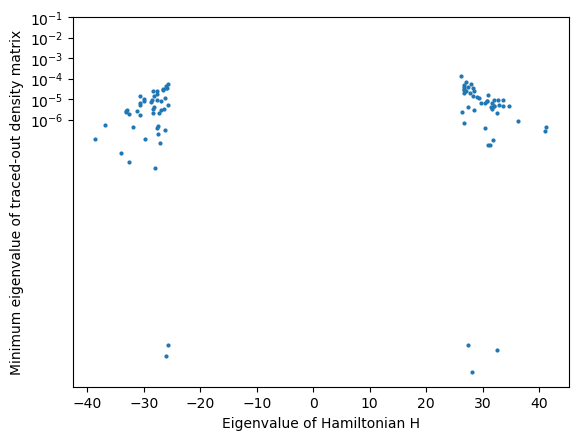

In [ ]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [ ]:
# All eigenvalues of H

# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out 9 qubits (keep 3 qubits)
    keep_qubits = [4, 5, 6, 7]  # Indices of qubits to keep
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Print the rank of the traced out density matrix
    rank = np.linalg.matrix_rank(traced_out_density_matrix)
    #print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced), 
    min_eigenvalues.append(min_eigenvalue)

  0%|          | 1/4096 [00:00<30:54,  2.21it/s]

Eigenvector 0: Rank of traced out density matrix: 1


  0%|          | 2/4096 [00:00<31:49,  2.14it/s]

Eigenvector 1: Rank of traced out density matrix: 1


  0%|          | 3/4096 [00:01<34:06,  2.00it/s]

Eigenvector 2: Rank of traced out density matrix: 1


  0%|          | 4/4096 [00:02<38:08,  1.79it/s]

Eigenvector 3: Rank of traced out density matrix: 1


  0%|          | 5/4096 [00:02<38:03,  1.79it/s]

Eigenvector 4: Rank of traced out density matrix: 1


  0%|          | 6/4096 [00:03<38:15,  1.78it/s]

Eigenvector 5: Rank of traced out density matrix: 1


  0%|          | 7/4096 [00:03<37:07,  1.84it/s]

Eigenvector 6: Rank of traced out density matrix: 1


  0%|          | 8/4096 [00:04<38:12,  1.78it/s]

Eigenvector 7: Rank of traced out density matrix: 1


  0%|          | 9/4096 [00:04<38:15,  1.78it/s]

Eigenvector 8: Rank of traced out density matrix: 1


  0%|          | 10/4096 [00:05<38:02,  1.79it/s]

Eigenvector 9: Rank of traced out density matrix: 1


  0%|          | 11/4096 [00:05<35:29,  1.92it/s]

Eigenvector 10: Rank of traced out density matrix: 1


  0%|          | 12/4096 [00:06<34:50,  1.95it/s]

Eigenvector 11: Rank of traced out density matrix: 1


  0%|          | 13/4096 [00:06<35:09,  1.94it/s]

Eigenvector 12: Rank of traced out density matrix: 1


  0%|          | 14/4096 [00:07<33:28,  2.03it/s]

Eigenvector 13: Rank of traced out density matrix: 1


  0%|          | 15/4096 [00:08<38:14,  1.78it/s]

Eigenvector 14: Rank of traced out density matrix: 1


  0%|          | 16/4096 [00:08<36:17,  1.87it/s]

Eigenvector 15: Rank of traced out density matrix: 1


  0%|          | 17/4096 [00:09<35:04,  1.94it/s]

Eigenvector 16: Rank of traced out density matrix: 1


  0%|          | 18/4096 [00:09<33:15,  2.04it/s]

Eigenvector 17: Rank of traced out density matrix: 1


  0%|          | 19/4096 [00:09<34:26,  1.97it/s]

Eigenvector 18: Rank of traced out density matrix: 1


  0%|          | 20/4096 [00:10<32:21,  2.10it/s]

Eigenvector 19: Rank of traced out density matrix: 1


  1%|          | 21/4096 [00:10<32:08,  2.11it/s]

Eigenvector 20: Rank of traced out density matrix: 1


  1%|          | 22/4096 [00:11<30:57,  2.19it/s]

Eigenvector 21: Rank of traced out density matrix: 1


  1%|          | 23/4096 [00:11<29:19,  2.31it/s]

Eigenvector 22: Rank of traced out density matrix: 1


  1%|          | 24/4096 [00:12<29:48,  2.28it/s]

Eigenvector 23: Rank of traced out density matrix: 1


  1%|          | 25/4096 [00:12<29:21,  2.31it/s]

Eigenvector 24: Rank of traced out density matrix: 1


  1%|          | 26/4096 [00:12<28:30,  2.38it/s]

Eigenvector 25: Rank of traced out density matrix: 1


  1%|          | 27/4096 [00:13<28:43,  2.36it/s]

Eigenvector 26: Rank of traced out density matrix: 1


  1%|          | 28/4096 [00:13<29:27,  2.30it/s]

Eigenvector 27: Rank of traced out density matrix: 1


  1%|          | 29/4096 [00:14<28:37,  2.37it/s]

Eigenvector 28: Rank of traced out density matrix: 1


  1%|          | 30/4096 [00:14<28:47,  2.35it/s]

Eigenvector 29: Rank of traced out density matrix: 1


  1%|          | 31/4096 [00:15<28:44,  2.36it/s]

Eigenvector 30: Rank of traced out density matrix: 1


  1%|          | 32/4096 [00:15<29:15,  2.31it/s]

Eigenvector 31: Rank of traced out density matrix: 1


  1%|          | 33/4096 [00:16<30:57,  2.19it/s]

Eigenvector 32: Rank of traced out density matrix: 1


  1%|          | 34/4096 [00:16<29:15,  2.31it/s]

Eigenvector 33: Rank of traced out density matrix: 1


  1%|          | 35/4096 [00:16<27:47,  2.44it/s]

Eigenvector 34: Rank of traced out density matrix: 1


  1%|          | 36/4096 [00:17<26:45,  2.53it/s]

Eigenvector 35: Rank of traced out density matrix: 1


  1%|          | 37/4096 [00:17<27:14,  2.48it/s]

Eigenvector 36: Rank of traced out density matrix: 1


  1%|          | 38/4096 [00:18<32:59,  2.05it/s]

Eigenvector 37: Rank of traced out density matrix: 1


  1%|          | 39/4096 [00:18<30:47,  2.20it/s]

Eigenvector 38: Rank of traced out density matrix: 1


  1%|          | 40/4096 [00:19<30:21,  2.23it/s]

Eigenvector 39: Rank of traced out density matrix: 1


  1%|          | 41/4096 [00:19<28:46,  2.35it/s]

Eigenvector 40: Rank of traced out density matrix: 1


  1%|          | 42/4096 [00:19<27:33,  2.45it/s]

Eigenvector 41: Rank of traced out density matrix: 1


  1%|          | 43/4096 [00:20<26:52,  2.51it/s]

Eigenvector 42: Rank of traced out density matrix: 1


  1%|          | 44/4096 [00:20<27:06,  2.49it/s]

Eigenvector 43: Rank of traced out density matrix: 1


  1%|          | 45/4096 [00:20<26:32,  2.54it/s]

Eigenvector 44: Rank of traced out density matrix: 1


  1%|          | 46/4096 [00:21<24:51,  2.72it/s]

Eigenvector 45: Rank of traced out density matrix: 1


  1%|          | 47/4096 [00:21<24:11,  2.79it/s]

Eigenvector 46: Rank of traced out density matrix: 1


  1%|          | 48/4096 [00:21<25:05,  2.69it/s]

Eigenvector 47: Rank of traced out density matrix: 1


  1%|          | 49/4096 [00:22<25:18,  2.66it/s]

Eigenvector 48: Rank of traced out density matrix: 1


  1%|          | 50/4096 [00:22<25:45,  2.62it/s]

Eigenvector 49: Rank of traced out density matrix: 1


  1%|          | 51/4096 [00:23<24:59,  2.70it/s]

Eigenvector 50: Rank of traced out density matrix: 1


  1%|▏         | 52/4096 [00:23<24:48,  2.72it/s]

Eigenvector 51: Rank of traced out density matrix: 1


  1%|▏         | 53/4096 [00:23<25:43,  2.62it/s]

Eigenvector 52: Rank of traced out density matrix: 1


  1%|▏         | 54/4096 [00:24<27:07,  2.48it/s]

Eigenvector 53: Rank of traced out density matrix: 1


  1%|▏         | 55/4096 [00:24<26:59,  2.50it/s]

Eigenvector 54: Rank of traced out density matrix: 1


  1%|▏         | 56/4096 [00:25<30:34,  2.20it/s]

Eigenvector 55: Rank of traced out density matrix: 1


  1%|▏         | 57/4096 [00:26<39:16,  1.71it/s]

Eigenvector 56: Rank of traced out density matrix: 1


  1%|▏         | 58/4096 [00:26<40:22,  1.67it/s]

Eigenvector 57: Rank of traced out density matrix: 1


  1%|▏         | 59/4096 [00:27<38:33,  1.75it/s]

Eigenvector 58: Rank of traced out density matrix: 1


  1%|▏         | 60/4096 [00:27<37:02,  1.82it/s]

Eigenvector 59: Rank of traced out density matrix: 1


  1%|▏         | 61/4096 [00:28<33:42,  1.99it/s]

Eigenvector 60: Rank of traced out density matrix: 1


  2%|▏         | 62/4096 [00:28<32:41,  2.06it/s]

Eigenvector 61: Rank of traced out density matrix: 1


  2%|▏         | 63/4096 [00:29<29:41,  2.26it/s]

Eigenvector 62: Rank of traced out density matrix: 1


  2%|▏         | 64/4096 [00:29<29:10,  2.30it/s]

Eigenvector 63: Rank of traced out density matrix: 1


  2%|▏         | 65/4096 [00:29<27:20,  2.46it/s]

Eigenvector 64: Rank of traced out density matrix: 1


  2%|▏         | 66/4096 [00:30<25:30,  2.63it/s]

Eigenvector 65: Rank of traced out density matrix: 1


  2%|▏         | 67/4096 [00:30<26:11,  2.56it/s]

Eigenvector 66: Rank of traced out density matrix: 1


  2%|▏         | 68/4096 [00:30<25:26,  2.64it/s]

Eigenvector 67: Rank of traced out density matrix: 1


  2%|▏         | 69/4096 [00:31<25:02,  2.68it/s]

Eigenvector 68: Rank of traced out density matrix: 1


  2%|▏         | 70/4096 [00:31<24:29,  2.74it/s]

Eigenvector 69: Rank of traced out density matrix: 1


  2%|▏         | 71/4096 [00:31<24:44,  2.71it/s]

Eigenvector 70: Rank of traced out density matrix: 1


  2%|▏         | 72/4096 [00:32<25:20,  2.65it/s]

Eigenvector 71: Rank of traced out density matrix: 1


  2%|▏         | 73/4096 [00:32<25:17,  2.65it/s]

Eigenvector 72: Rank of traced out density matrix: 1


  2%|▏         | 74/4096 [00:33<25:02,  2.68it/s]

Eigenvector 73: Rank of traced out density matrix: 1


  2%|▏         | 75/4096 [00:33<24:32,  2.73it/s]

Eigenvector 74: Rank of traced out density matrix: 1


  2%|▏         | 76/4096 [00:33<24:22,  2.75it/s]

Eigenvector 75: Rank of traced out density matrix: 1


  2%|▏         | 77/4096 [00:34<24:09,  2.77it/s]

Eigenvector 76: Rank of traced out density matrix: 1


  2%|▏         | 78/4096 [00:34<25:08,  2.66it/s]

Eigenvector 77: Rank of traced out density matrix: 1


  2%|▏         | 79/4096 [00:34<26:13,  2.55it/s]

Eigenvector 78: Rank of traced out density matrix: 1


  2%|▏         | 80/4096 [00:35<26:01,  2.57it/s]

Eigenvector 79: Rank of traced out density matrix: 1


  2%|▏         | 81/4096 [00:35<26:04,  2.57it/s]

Eigenvector 80: Rank of traced out density matrix: 1


  2%|▏         | 82/4096 [00:36<26:42,  2.51it/s]

Eigenvector 81: Rank of traced out density matrix: 1


  2%|▏         | 83/4096 [00:36<26:49,  2.49it/s]

Eigenvector 82: Rank of traced out density matrix: 1


  2%|▏         | 84/4096 [00:36<26:59,  2.48it/s]

Eigenvector 83: Rank of traced out density matrix: 1


  2%|▏         | 85/4096 [00:37<26:34,  2.52it/s]

Eigenvector 84: Rank of traced out density matrix: 1


  2%|▏         | 86/4096 [00:37<26:36,  2.51it/s]

Eigenvector 85: Rank of traced out density matrix: 1


  2%|▏         | 87/4096 [00:38<26:02,  2.56it/s]

Eigenvector 86: Rank of traced out density matrix: 1


  2%|▏         | 88/4096 [00:38<25:48,  2.59it/s]

Eigenvector 87: Rank of traced out density matrix: 1


  2%|▏         | 89/4096 [00:38<25:38,  2.60it/s]

Eigenvector 88: Rank of traced out density matrix: 1


  2%|▏         | 90/4096 [00:39<25:02,  2.67it/s]

Eigenvector 89: Rank of traced out density matrix: 1


  2%|▏         | 91/4096 [00:39<25:02,  2.67it/s]

Eigenvector 90: Rank of traced out density matrix: 1


  2%|▏         | 92/4096 [00:40<25:04,  2.66it/s]

Eigenvector 91: Rank of traced out density matrix: 1


  2%|▏         | 93/4096 [00:40<24:41,  2.70it/s]

Eigenvector 92: Rank of traced out density matrix: 1


  2%|▏         | 94/4096 [00:40<25:22,  2.63it/s]

Eigenvector 93: Rank of traced out density matrix: 1


  2%|▏         | 95/4096 [00:41<25:56,  2.57it/s]

Eigenvector 94: Rank of traced out density matrix: 1


  2%|▏         | 96/4096 [00:41<27:58,  2.38it/s]

Eigenvector 95: Rank of traced out density matrix: 1


  2%|▏         | 97/4096 [00:42<31:04,  2.14it/s]

Eigenvector 96: Rank of traced out density matrix: 1


  2%|▏         | 98/4096 [00:46<1:41:02,  1.52s/it]

Eigenvector 97: Rank of traced out density matrix: 1


  2%|▏         | 99/4096 [00:53<3:26:31,  3.10s/it]

Eigenvector 98: Rank of traced out density matrix: 1


  2%|▏         | 100/4096 [00:58<4:12:10,  3.79s/it]

Eigenvector 99: Rank of traced out density matrix: 1


  2%|▏         | 101/4096 [00:58<3:03:29,  2.76s/it]

Eigenvector 100: Rank of traced out density matrix: 1


  2%|▏         | 102/4096 [01:03<3:45:08,  3.38s/it]

Eigenvector 101: Rank of traced out density matrix: 1


  3%|▎         | 103/4096 [01:05<3:09:31,  2.85s/it]

Eigenvector 102: Rank of traced out density matrix: 1


  3%|▎         | 104/4096 [01:05<2:20:49,  2.12s/it]

Eigenvector 103: Rank of traced out density matrix: 1


  3%|▎         | 105/4096 [01:05<1:46:19,  1.60s/it]

Eigenvector 104: Rank of traced out density matrix: 1


  3%|▎         | 106/4096 [01:06<1:21:12,  1.22s/it]

Eigenvector 105: Rank of traced out density matrix: 1


  3%|▎         | 107/4096 [01:06<1:02:59,  1.06it/s]

Eigenvector 106: Rank of traced out density matrix: 1


  3%|▎         | 108/4096 [01:06<50:28,  1.32it/s]  

Eigenvector 107: Rank of traced out density matrix: 1


  3%|▎         | 109/4096 [01:07<41:32,  1.60it/s]

Eigenvector 108: Rank of traced out density matrix: 1


  3%|▎         | 110/4096 [01:07<35:05,  1.89it/s]

Eigenvector 109: Rank of traced out density matrix: 1


  3%|▎         | 111/4096 [01:07<30:39,  2.17it/s]

Eigenvector 110: Rank of traced out density matrix: 1


  3%|▎         | 112/4096 [01:08<27:34,  2.41it/s]

Eigenvector 111: Rank of traced out density matrix: 1


  3%|▎         | 113/4096 [01:08<26:19,  2.52it/s]

Eigenvector 112: Rank of traced out density matrix: 1


  3%|▎         | 114/4096 [01:08<24:11,  2.74it/s]

Eigenvector 113: Rank of traced out density matrix: 1


  3%|▎         | 115/4096 [01:09<23:09,  2.86it/s]

Eigenvector 114: Rank of traced out density matrix: 1


  3%|▎         | 116/4096 [01:09<23:30,  2.82it/s]

Eigenvector 115: Rank of traced out density matrix: 1


  3%|▎         | 117/4096 [01:09<23:20,  2.84it/s]

Eigenvector 116: Rank of traced out density matrix: 1


  3%|▎         | 118/4096 [01:10<22:42,  2.92it/s]

Eigenvector 117: Rank of traced out density matrix: 1


  3%|▎         | 119/4096 [01:10<23:07,  2.87it/s]

Eigenvector 118: Rank of traced out density matrix: 1


  3%|▎         | 120/4096 [01:10<21:48,  3.04it/s]

Eigenvector 119: Rank of traced out density matrix: 1


  3%|▎         | 121/4096 [01:11<21:33,  3.07it/s]

Eigenvector 120: Rank of traced out density matrix: 1


  3%|▎         | 122/4096 [01:11<22:45,  2.91it/s]

Eigenvector 121: Rank of traced out density matrix: 1


  3%|▎         | 123/4096 [01:11<22:45,  2.91it/s]

Eigenvector 122: Rank of traced out density matrix: 1


  3%|▎         | 124/4096 [01:12<22:29,  2.94it/s]

Eigenvector 123: Rank of traced out density matrix: 1


  3%|▎         | 125/4096 [01:12<23:28,  2.82it/s]

Eigenvector 124: Rank of traced out density matrix: 1


  3%|▎         | 126/4096 [01:12<22:41,  2.92it/s]

Eigenvector 125: Rank of traced out density matrix: 1


  3%|▎         | 127/4096 [01:13<23:54,  2.77it/s]

Eigenvector 126: Rank of traced out density matrix: 1


  3%|▎         | 128/4096 [01:17<1:42:43,  1.55s/it]

Eigenvector 127: Rank of traced out density matrix: 1


  3%|▎         | 129/4096 [01:19<1:50:15,  1.67s/it]

Eigenvector 128: Rank of traced out density matrix: 1


  3%|▎         | 130/4096 [01:19<1:24:07,  1.27s/it]

Eigenvector 129: Rank of traced out density matrix: 1


  3%|▎         | 131/4096 [01:20<1:06:00,  1.00it/s]

Eigenvector 130: Rank of traced out density matrix: 1


  3%|▎         | 132/4096 [01:20<52:19,  1.26it/s]  

Eigenvector 131: Rank of traced out density matrix: 1


  3%|▎         | 133/4096 [01:20<42:34,  1.55it/s]

Eigenvector 132: Rank of traced out density matrix: 1


  3%|▎         | 134/4096 [01:21<35:40,  1.85it/s]

Eigenvector 133: Rank of traced out density matrix: 1


  3%|▎         | 135/4096 [01:21<31:39,  2.09it/s]

Eigenvector 134: Rank of traced out density matrix: 1


  3%|▎         | 136/4096 [01:21<30:12,  2.18it/s]

Eigenvector 135: Rank of traced out density matrix: 1


  3%|▎         | 137/4096 [01:22<33:13,  1.99it/s]

Eigenvector 136: Rank of traced out density matrix: 1


  3%|▎         | 138/4096 [01:23<32:54,  2.00it/s]

Eigenvector 137: Rank of traced out density matrix: 1


  3%|▎         | 139/4096 [01:23<31:57,  2.06it/s]

Eigenvector 138: Rank of traced out density matrix: 1


  3%|▎         | 140/4096 [01:23<29:30,  2.23it/s]

Eigenvector 139: Rank of traced out density matrix: 1


  3%|▎         | 141/4096 [01:24<27:53,  2.36it/s]

Eigenvector 140: Rank of traced out density matrix: 1


  3%|▎         | 142/4096 [01:24<26:22,  2.50it/s]

Eigenvector 141: Rank of traced out density matrix: 1


  3%|▎         | 143/4096 [01:25<44:33,  1.48it/s]

Eigenvector 142: Rank of traced out density matrix: 1


  4%|▎         | 144/4096 [01:28<1:19:21,  1.20s/it]

Eigenvector 143: Rank of traced out density matrix: 1


  4%|▎         | 145/4096 [01:31<1:59:58,  1.82s/it]

Eigenvector 144: Rank of traced out density matrix: 1


  4%|▎         | 146/4096 [01:33<2:05:13,  1.90s/it]

Eigenvector 145: Rank of traced out density matrix: 1


  4%|▎         | 147/4096 [01:36<2:22:30,  2.17s/it]

Eigenvector 146: Rank of traced out density matrix: 1


  4%|▎         | 148/4096 [01:38<2:22:40,  2.17s/it]

Eigenvector 147: Rank of traced out density matrix: 1


  4%|▎         | 149/4096 [01:40<2:20:51,  2.14s/it]

Eigenvector 148: Rank of traced out density matrix: 1


  4%|▎         | 150/4096 [01:42<2:21:56,  2.16s/it]

Eigenvector 149: Rank of traced out density matrix: 1


  4%|▎         | 151/4096 [01:45<2:24:13,  2.19s/it]

Eigenvector 150: Rank of traced out density matrix: 1


  4%|▎         | 152/4096 [01:46<2:08:18,  1.95s/it]

Eigenvector 151: Rank of traced out density matrix: 1


  4%|▎         | 153/4096 [01:47<1:53:10,  1.72s/it]

Eigenvector 152: Rank of traced out density matrix: 1


  4%|▍         | 154/4096 [01:48<1:36:06,  1.46s/it]

Eigenvector 153: Rank of traced out density matrix: 1


  4%|▍         | 155/4096 [01:49<1:25:15,  1.30s/it]

Eigenvector 154: Rank of traced out density matrix: 1


  4%|▍         | 156/4096 [01:50<1:19:09,  1.21s/it]

Eigenvector 155: Rank of traced out density matrix: 1


  4%|▍         | 157/4096 [01:57<3:20:51,  3.06s/it]

Eigenvector 156: Rank of traced out density matrix: 1


  4%|▍         | 158/4096 [02:02<3:45:25,  3.43s/it]

Eigenvector 157: Rank of traced out density matrix: 1


  4%|▍         | 159/4096 [02:06<4:04:55,  3.73s/it]

Eigenvector 158: Rank of traced out density matrix: 1


  4%|▍         | 160/4096 [02:10<4:15:54,  3.90s/it]

Eigenvector 159: Rank of traced out density matrix: 1


  4%|▍         | 161/4096 [02:14<4:17:30,  3.93s/it]

Eigenvector 160: Rank of traced out density matrix: 1


  4%|▍         | 162/4096 [02:19<4:22:14,  4.00s/it]

Eigenvector 161: Rank of traced out density matrix: 1


  4%|▍         | 163/4096 [02:23<4:21:20,  3.99s/it]

Eigenvector 162: Rank of traced out density matrix: 1


  4%|▍         | 164/4096 [02:27<4:22:42,  4.01s/it]

Eigenvector 163: Rank of traced out density matrix: 1


  4%|▍         | 165/4096 [02:31<4:25:42,  4.06s/it]

Eigenvector 164: Rank of traced out density matrix: 1


  4%|▍         | 166/4096 [02:35<4:27:06,  4.08s/it]

Eigenvector 165: Rank of traced out density matrix: 1


  4%|▍         | 167/4096 [02:39<4:32:04,  4.15s/it]

Eigenvector 166: Rank of traced out density matrix: 1


  4%|▍         | 168/4096 [02:43<4:33:56,  4.18s/it]

Eigenvector 167: Rank of traced out density matrix: 1


  4%|▍         | 169/4096 [02:48<4:34:50,  4.20s/it]

Eigenvector 168: Rank of traced out density matrix: 1


  4%|▍         | 170/4096 [02:51<4:09:10,  3.81s/it]

Eigenvector 169: Rank of traced out density matrix: 1


  4%|▍         | 171/4096 [02:55<4:13:54,  3.88s/it]

Eigenvector 170: Rank of traced out density matrix: 1


  4%|▍         | 172/4096 [02:59<4:19:51,  3.97s/it]

Eigenvector 171: Rank of traced out density matrix: 1


  4%|▍         | 173/4096 [03:04<4:34:23,  4.20s/it]

Eigenvector 172: Rank of traced out density matrix: 1


  4%|▍         | 174/4096 [03:08<4:48:00,  4.41s/it]

Eigenvector 173: Rank of traced out density matrix: 1


  4%|▍         | 175/4096 [03:14<5:14:45,  4.82s/it]

Eigenvector 174: Rank of traced out density matrix: 1


  4%|▍         | 176/4096 [03:18<5:00:12,  4.60s/it]

Eigenvector 175: Rank of traced out density matrix: 1


  4%|▍         | 177/4096 [03:23<4:55:48,  4.53s/it]

Eigenvector 176: Rank of traced out density matrix: 1


  4%|▍         | 178/4096 [03:27<4:51:16,  4.46s/it]

Eigenvector 177: Rank of traced out density matrix: 1


  4%|▍         | 179/4096 [03:31<4:43:57,  4.35s/it]

Eigenvector 178: Rank of traced out density matrix: 1


  4%|▍         | 180/4096 [03:35<4:43:45,  4.35s/it]

Eigenvector 179: Rank of traced out density matrix: 1


  4%|▍         | 181/4096 [03:40<4:41:53,  4.32s/it]

Eigenvector 180: Rank of traced out density matrix: 1


  4%|▍         | 182/4096 [03:44<4:42:10,  4.33s/it]

Eigenvector 181: Rank of traced out density matrix: 1


  4%|▍         | 183/4096 [03:48<4:34:41,  4.21s/it]

Eigenvector 182: Rank of traced out density matrix: 1


  4%|▍         | 184/4096 [03:49<3:29:09,  3.21s/it]

Eigenvector 183: Rank of traced out density matrix: 1


  5%|▍         | 185/4096 [03:50<2:40:06,  2.46s/it]

Eigenvector 184: Rank of traced out density matrix: 1


  5%|▍         | 186/4096 [03:55<3:36:16,  3.32s/it]

Eigenvector 185: Rank of traced out density matrix: 1


  5%|▍         | 187/4096 [04:06<5:59:18,  5.52s/it]

Eigenvector 186: Rank of traced out density matrix: 1


  5%|▍         | 188/4096 [04:19<8:28:00,  7.80s/it]

Eigenvector 187: Rank of traced out density matrix: 1


  5%|▍         | 189/4096 [04:34<10:53:20, 10.03s/it]

Eigenvector 188: Rank of traced out density matrix: 1


  5%|▍         | 190/4096 [04:40<9:34:02,  8.82s/it] 

Eigenvector 189: Rank of traced out density matrix: 1


  5%|▍         | 191/4096 [04:42<7:26:50,  6.87s/it]

Eigenvector 190: Rank of traced out density matrix: 1


  5%|▍         | 192/4096 [04:47<6:54:38,  6.37s/it]

Eigenvector 191: Rank of traced out density matrix: 1


  5%|▍         | 193/4096 [04:52<6:13:50,  5.75s/it]

Eigenvector 192: Rank of traced out density matrix: 1


  5%|▍         | 194/4096 [04:54<5:13:07,  4.81s/it]

Eigenvector 193: Rank of traced out density matrix: 1


  5%|▍         | 195/4096 [04:55<3:52:17,  3.57s/it]

Eigenvector 194: Rank of traced out density matrix: 1


  5%|▍         | 196/4096 [04:56<2:56:05,  2.71s/it]

Eigenvector 195: Rank of traced out density matrix: 1


  5%|▍         | 197/4096 [04:57<2:18:46,  2.14s/it]

Eigenvector 196: Rank of traced out density matrix: 1


  5%|▍         | 198/4096 [05:02<3:26:11,  3.17s/it]

Eigenvector 197: Rank of traced out density matrix: 1


  5%|▍         | 199/4096 [05:03<2:36:11,  2.40s/it]

Eigenvector 198: Rank of traced out density matrix: 1


  5%|▍         | 200/4096 [05:03<2:00:36,  1.86s/it]

Eigenvector 199: Rank of traced out density matrix: 1


  5%|▍         | 201/4096 [05:04<1:36:40,  1.49s/it]

Eigenvector 200: Rank of traced out density matrix: 1


  5%|▍         | 202/4096 [05:05<1:19:57,  1.23s/it]

Eigenvector 201: Rank of traced out density matrix: 1


  5%|▍         | 203/4096 [05:05<1:08:34,  1.06s/it]

Eigenvector 202: Rank of traced out density matrix: 1


  5%|▍         | 204/4096 [05:08<1:41:10,  1.56s/it]

Eigenvector 203: Rank of traced out density matrix: 1


  5%|▌         | 205/4096 [05:17<4:15:38,  3.94s/it]

Eigenvector 204: Rank of traced out density matrix: 1


  5%|▌         | 206/4096 [05:18<3:12:07,  2.96s/it]

Eigenvector 205: Rank of traced out density matrix: 1


  5%|▌         | 207/4096 [05:19<2:25:41,  2.25s/it]

Eigenvector 206: Rank of traced out density matrix: 1


  5%|▌         | 208/4096 [05:19<1:55:08,  1.78s/it]

Eigenvector 207: Rank of traced out density matrix: 1


  5%|▌         | 209/4096 [05:20<1:32:39,  1.43s/it]

Eigenvector 208: Rank of traced out density matrix: 1


  5%|▌         | 210/4096 [05:21<1:16:40,  1.18s/it]

Eigenvector 209: Rank of traced out density matrix: 1


  5%|▌         | 211/4096 [05:21<1:07:10,  1.04s/it]

Eigenvector 210: Rank of traced out density matrix: 1


  5%|▌         | 212/4096 [05:22<59:19,  1.09it/s]  

Eigenvector 211: Rank of traced out density matrix: 1


  5%|▌         | 213/4096 [05:23<53:46,  1.20it/s]

Eigenvector 212: Rank of traced out density matrix: 1


  5%|▌         | 214/4096 [05:23<51:43,  1.25it/s]

Eigenvector 213: Rank of traced out density matrix: 1


  5%|▌         | 215/4096 [05:24<50:22,  1.28it/s]

Eigenvector 214: Rank of traced out density matrix: 1


  5%|▌         | 216/4096 [05:25<50:54,  1.27it/s]

Eigenvector 215: Rank of traced out density matrix: 1


  5%|▌         | 217/4096 [05:26<51:14,  1.26it/s]

Eigenvector 216: Rank of traced out density matrix: 1


  5%|▌         | 218/4096 [05:30<1:58:11,  1.83s/it]

Eigenvector 217: Rank of traced out density matrix: 1


  5%|▌         | 219/4096 [05:40<4:39:30,  4.33s/it]

Eigenvector 218: Rank of traced out density matrix: 1


  5%|▌         | 220/4096 [05:50<6:32:49,  6.08s/it]

Eigenvector 219: Rank of traced out density matrix: 1


  5%|▌         | 221/4096 [05:54<5:56:02,  5.51s/it]

Eigenvector 220: Rank of traced out density matrix: 1


  5%|▌         | 222/4096 [05:56<4:45:48,  4.43s/it]

Eigenvector 221: Rank of traced out density matrix: 1


  5%|▌         | 223/4096 [06:09<7:17:26,  6.78s/it]

Eigenvector 222: Rank of traced out density matrix: 1


  5%|▌         | 224/4096 [06:23<9:45:41,  9.08s/it]

Eigenvector 223: Rank of traced out density matrix: 1


  5%|▌         | 225/4096 [06:36<11:08:10, 10.36s/it]

Eigenvector 224: Rank of traced out density matrix: 1


  6%|▌         | 226/4096 [06:50<12:17:43, 11.44s/it]

Eigenvector 225: Rank of traced out density matrix: 1


  6%|▌         | 227/4096 [07:03<12:42:37, 11.83s/it]

Eigenvector 226: Rank of traced out density matrix: 1


  6%|▌         | 228/4096 [07:15<12:48:12, 11.92s/it]

Eigenvector 227: Rank of traced out density matrix: 1


  6%|▌         | 229/4096 [07:28<13:03:40, 12.16s/it]

Eigenvector 228: Rank of traced out density matrix: 1


  6%|▌         | 230/4096 [07:46<14:50:49, 13.83s/it]

Eigenvector 229: Rank of traced out density matrix: 1


  6%|▌         | 231/4096 [07:58<14:28:15, 13.48s/it]

Eigenvector 230: Rank of traced out density matrix: 1


  6%|▌         | 232/4096 [08:14<15:11:29, 14.15s/it]

Eigenvector 231: Rank of traced out density matrix: 1


  6%|▌         | 233/4096 [08:25<14:05:04, 13.13s/it]

Eigenvector 232: Rank of traced out density matrix: 1


  6%|▌         | 234/4096 [08:35<13:17:10, 12.39s/it]

Eigenvector 233: Rank of traced out density matrix: 1


  6%|▌         | 235/4096 [08:48<13:29:40, 12.58s/it]

Eigenvector 234: Rank of traced out density matrix: 1


  6%|▌         | 236/4096 [09:10<16:26:50, 15.34s/it]

Eigenvector 235: Rank of traced out density matrix: 1


  6%|▌         | 237/4096 [09:25<16:18:31, 15.21s/it]

Eigenvector 236: Rank of traced out density matrix: 1


  6%|▌         | 238/4096 [09:39<15:49:04, 14.76s/it]

Eigenvector 237: Rank of traced out density matrix: 1


  6%|▌         | 239/4096 [09:52<15:17:25, 14.27s/it]

Eigenvector 238: Rank of traced out density matrix: 1


  6%|▌         | 240/4096 [10:06<15:06:14, 14.10s/it]

Eigenvector 239: Rank of traced out density matrix: 1


  6%|▌         | 241/4096 [10:19<14:51:13, 13.87s/it]

Eigenvector 240: Rank of traced out density matrix: 1


  6%|▌         | 242/4096 [10:33<14:51:02, 13.87s/it]

Eigenvector 241: Rank of traced out density matrix: 1


  6%|▌         | 243/4096 [10:40<12:35:44, 11.77s/it]

Eigenvector 242: Rank of traced out density matrix: 1


  6%|▌         | 244/4096 [10:41<9:03:54,  8.47s/it] 

Eigenvector 243: Rank of traced out density matrix: 1


  6%|▌         | 245/4096 [10:41<6:35:33,  6.16s/it]

Eigenvector 244: Rank of traced out density matrix: 1


  6%|▌         | 246/4096 [10:42<4:53:16,  4.57s/it]

Eigenvector 245: Rank of traced out density matrix: 1


  6%|▌         | 247/4096 [10:47<4:55:06,  4.60s/it]

Eigenvector 246: Rank of traced out density matrix: 1


  6%|▌         | 248/4096 [11:03<8:37:11,  8.06s/it]

Eigenvector 247: Rank of traced out density matrix: 1


  6%|▌         | 249/4096 [11:18<10:56:04, 10.23s/it]

Eigenvector 248: Rank of traced out density matrix: 1


  6%|▌         | 250/4096 [11:33<12:16:09, 11.48s/it]

Eigenvector 249: Rank of traced out density matrix: 1


  6%|▌         | 251/4096 [11:45<12:32:18, 11.74s/it]

Eigenvector 250: Rank of traced out density matrix: 1


  6%|▌         | 252/4096 [11:54<11:45:31, 11.01s/it]

Eigenvector 251: Rank of traced out density matrix: 1


  6%|▌         | 253/4096 [11:56<8:43:46,  8.18s/it] 

Eigenvector 252: Rank of traced out density matrix: 1


  6%|▌         | 254/4096 [12:06<9:19:40,  8.74s/it]

Eigenvector 253: Rank of traced out density matrix: 1


  6%|▌         | 255/4096 [12:16<9:50:19,  9.22s/it]

Eigenvector 254: Rank of traced out density matrix: 1


  6%|▋         | 256/4096 [12:29<10:57:54, 10.28s/it]

Eigenvector 255: Rank of traced out density matrix: 1


  6%|▋         | 257/4096 [12:44<12:35:49, 11.81s/it]

Eigenvector 256: Rank of traced out density matrix: 1


  6%|▋         | 258/4096 [12:59<13:35:03, 12.74s/it]

Eigenvector 257: Rank of traced out density matrix: 1


  6%|▋         | 259/4096 [13:14<14:14:49, 13.37s/it]

Eigenvector 258: Rank of traced out density matrix: 1


  6%|▋         | 260/4096 [13:28<14:19:33, 13.44s/it]

Eigenvector 259: Rank of traced out density matrix: 1


  6%|▋         | 261/4096 [13:42<14:27:55, 13.58s/it]

Eigenvector 260: Rank of traced out density matrix: 1


  6%|▋         | 262/4096 [13:55<14:31:40, 13.64s/it]

Eigenvector 261: Rank of traced out density matrix: 1


  6%|▋         | 263/4096 [14:06<13:24:00, 12.59s/it]

Eigenvector 262: Rank of traced out density matrix: 1


  6%|▋         | 264/4096 [14:20<13:58:13, 13.12s/it]

Eigenvector 263: Rank of traced out density matrix: 1


  6%|▋         | 265/4096 [14:33<13:59:20, 13.15s/it]

Eigenvector 264: Rank of traced out density matrix: 1


  6%|▋         | 266/4096 [14:44<13:22:49, 12.58s/it]

Eigenvector 265: Rank of traced out density matrix: 1


  7%|▋         | 267/4096 [14:56<13:08:49, 12.36s/it]

Eigenvector 266: Rank of traced out density matrix: 1


  7%|▋         | 268/4096 [15:08<13:03:54, 12.29s/it]

Eigenvector 267: Rank of traced out density matrix: 1


  7%|▋         | 269/4096 [15:21<13:05:35, 12.32s/it]

Eigenvector 268: Rank of traced out density matrix: 1


  7%|▋         | 270/4096 [15:33<12:54:36, 12.15s/it]

Eigenvector 269: Rank of traced out density matrix: 1


  7%|▋         | 271/4096 [15:42<12:05:52, 11.39s/it]

Eigenvector 270: Rank of traced out density matrix: 1


  7%|▋         | 272/4096 [15:43<8:40:07,  8.16s/it] 

Eigenvector 271: Rank of traced out density matrix: 1


  7%|▋         | 273/4096 [15:43<6:17:14,  5.92s/it]

Eigenvector 272: Rank of traced out density matrix: 1


  7%|▋         | 274/4096 [15:44<4:38:11,  4.37s/it]

Eigenvector 273: Rank of traced out density matrix: 1


  7%|▋         | 275/4096 [15:45<3:29:48,  3.29s/it]

Eigenvector 274: Rank of traced out density matrix: 1


  7%|▋         | 276/4096 [15:50<3:59:19,  3.76s/it]

Eigenvector 275: Rank of traced out density matrix: 1


  7%|▋         | 277/4096 [15:50<2:57:11,  2.78s/it]

Eigenvector 276: Rank of traced out density matrix: 1


  7%|▋         | 278/4096 [15:51<2:17:03,  2.15s/it]

Eigenvector 277: Rank of traced out density matrix: 1


  7%|▋         | 279/4096 [15:52<1:49:02,  1.71s/it]

Eigenvector 278: Rank of traced out density matrix: 1


  7%|▋         | 280/4096 [15:52<1:29:15,  1.40s/it]

Eigenvector 279: Rank of traced out density matrix: 1


  7%|▋         | 281/4096 [15:53<1:15:55,  1.19s/it]

Eigenvector 280: Rank of traced out density matrix: 1


  7%|▋         | 282/4096 [15:54<1:06:04,  1.04s/it]

Eigenvector 281: Rank of traced out density matrix: 1


  7%|▋         | 283/4096 [15:54<58:15,  1.09it/s]  

Eigenvector 282: Rank of traced out density matrix: 1


  7%|▋         | 284/4096 [15:55<51:20,  1.24it/s]

Eigenvector 283: Rank of traced out density matrix: 1


  7%|▋         | 285/4096 [15:55<46:12,  1.37it/s]

Eigenvector 284: Rank of traced out density matrix: 1


  7%|▋         | 286/4096 [15:56<42:32,  1.49it/s]

Eigenvector 285: Rank of traced out density matrix: 1


  7%|▋         | 287/4096 [15:57<39:25,  1.61it/s]

Eigenvector 286: Rank of traced out density matrix: 1


  7%|▋         | 288/4096 [15:57<37:35,  1.69it/s]

Eigenvector 287: Rank of traced out density matrix: 1


  7%|▋         | 289/4096 [15:57<34:24,  1.84it/s]

Eigenvector 288: Rank of traced out density matrix: 1


  7%|▋         | 290/4096 [15:58<32:24,  1.96it/s]

Eigenvector 289: Rank of traced out density matrix: 1


  7%|▋         | 291/4096 [15:58<30:54,  2.05it/s]

Eigenvector 290: Rank of traced out density matrix: 1


  7%|▋         | 292/4096 [15:59<29:15,  2.17it/s]

Eigenvector 291: Rank of traced out density matrix: 1


  7%|▋         | 293/4096 [15:59<29:22,  2.16it/s]

Eigenvector 292: Rank of traced out density matrix: 1


  7%|▋         | 294/4096 [16:00<29:03,  2.18it/s]

Eigenvector 293: Rank of traced out density matrix: 1


  7%|▋         | 295/4096 [16:00<28:39,  2.21it/s]

Eigenvector 294: Rank of traced out density matrix: 1


  7%|▋         | 296/4096 [16:01<43:00,  1.47it/s]

Eigenvector 295: Rank of traced out density matrix: 1


  7%|▋         | 297/4096 [16:03<1:10:38,  1.12s/it]

Eigenvector 296: Rank of traced out density matrix: 1


  7%|▋         | 298/4096 [16:06<1:42:07,  1.61s/it]

Eigenvector 297: Rank of traced out density matrix: 1


  7%|▋         | 299/4096 [16:08<1:50:52,  1.75s/it]

Eigenvector 298: Rank of traced out density matrix: 1


  7%|▋         | 300/4096 [16:10<1:56:19,  1.84s/it]

Eigenvector 299: Rank of traced out density matrix: 1


  7%|▋         | 301/4096 [16:12<1:59:46,  1.89s/it]

Eigenvector 300: Rank of traced out density matrix: 1


  7%|▋         | 302/4096 [16:14<2:03:29,  1.95s/it]

Eigenvector 301: Rank of traced out density matrix: 1


  7%|▋         | 303/4096 [16:17<2:06:23,  2.00s/it]

Eigenvector 302: Rank of traced out density matrix: 1


  7%|▋         | 304/4096 [16:19<2:08:19,  2.03s/it]

Eigenvector 303: Rank of traced out density matrix: 1


  7%|▋         | 305/4096 [16:21<2:07:34,  2.02s/it]

Eigenvector 304: Rank of traced out density matrix: 1


  7%|▋         | 306/4096 [16:23<2:09:02,  2.04s/it]

Eigenvector 305: Rank of traced out density matrix: 1


  7%|▋         | 307/4096 [16:25<2:10:06,  2.06s/it]

Eigenvector 306: Rank of traced out density matrix: 1


  8%|▊         | 308/4096 [16:27<2:10:06,  2.06s/it]

Eigenvector 307: Rank of traced out density matrix: 1


  8%|▊         | 309/4096 [16:29<2:11:38,  2.09s/it]

Eigenvector 308: Rank of traced out density matrix: 1


  8%|▊         | 310/4096 [16:31<2:11:22,  2.08s/it]

Eigenvector 309: Rank of traced out density matrix: 1


  8%|▊         | 311/4096 [16:33<2:12:03,  2.09s/it]

Eigenvector 310: Rank of traced out density matrix: 1


  8%|▊         | 312/4096 [16:35<2:10:53,  2.08s/it]

Eigenvector 311: Rank of traced out density matrix: 1


  8%|▊         | 313/4096 [16:37<2:10:25,  2.07s/it]

Eigenvector 312: Rank of traced out density matrix: 1


  8%|▊         | 313/4096 [16:38<3:21:05,  3.19s/it]


KeyboardInterrupt: 

In [ ]:
print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))

Minimum eigenvalues of the traced-out density matrix: [1.42449004e-06 1.42449004e-06 2.58824074e-06 ... 9.64989148e-02
 9.75928035e-02 9.84196626e-02]


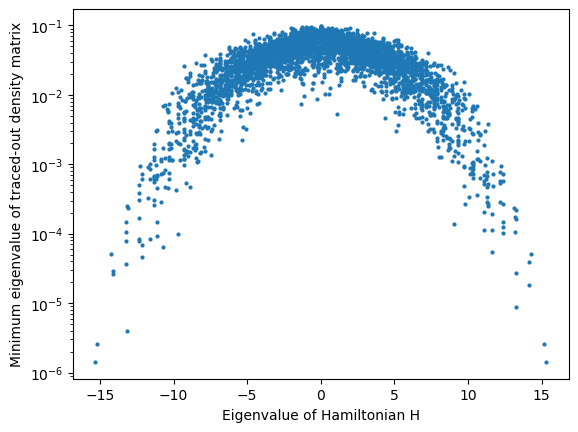

In [ ]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [ ]:
# ENTANGLEMENT ENTROPY COMPUTATION

# Compute entanglement entropy for all eigenstates in the full Hilbert space
subsystem_size = N // 2
entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, N) for i in range(eigenvectors.shape[1])]

print(len(entropies))

In [ ]:
# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, entropies, 'o', label='Entanglement entropy')
plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

In [ ]:
# print rank of rdms for different spins subsets and different values of h - trying to show that there are some non full rank rdms for eigenstates in the middle of the spectrum
# william found non full rank rdms for 4 adjacent spins in the middle of the spectrum (for h=3?)